In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import nltk
#set this path to where nltk is located
#if not downloaded, then comment this line out
nltk.data.path.append("/content/drive/My Drive/Colab Notebooks/nltk")
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle

from string import punctuation
from time import time
from ast import literal_eval
from gensim.models import KeyedVectors, TfidfModel
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
from gensim.corpora import Dictionary

from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.layers import Input, Embedding, LSTM, Lambda
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Adam

#Prepare the model for question similarity.

Import train and test dataset.
Set the path to where train and test dataset are located.
This dataset is retrieved from https://www.kaggle.com/c/quora-question-pairs/data.
Only the train dataset is used for this project as it lets us perform evaluation later on.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/data_files/'

data = pd.read_csv(path + 'train.csv')

In [0]:
print('Count null or nan values in train:')
print(data.isnull().sum())

Fill in null or nan values with empty string. This will help prevent crash in the code and will still allow us to compare question with another empty question.

In [0]:
data['question1'] = data['question1'].fillna('')
data['question2'] = data['question2'].fillna('')

Check for null or nan values for train and test dataset. It should be 0 now.

In [0]:
print('Count null or nan values in train:')
print(data.isnull().sum())

Tokenize and stem each question in train dataset. These couple of operations could take a long time to complete.

In [0]:
stop_words = nltk.corpus.stopwords.words("english")
porter_stemmer = nltk.stem.PorterStemmer()

data['q1_tokenized'] = data['question1'].apply(lambda x: nltk.word_tokenize(x))
data['q1_tokenized'] = data['q1_tokenized'].apply(lambda x: [word.strip().lower() for word in x])
data['q1_tokenized'] = data['q1_tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
data['q1_tokenized'] = data['q1_tokenized'].apply(lambda x: [porter_stemmer.stem(word) for word in x])

data['q2_tokenized'] = data['question2'].apply(lambda x: nltk.word_tokenize(x))
data['q2_tokenized'] = data['q2_tokenized'].apply(lambda x: [word.strip().lower() for word in x])
data['q2_tokenized'] = data['q2_tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
data['q2_tokenized'] = data['q2_tokenized'].apply(lambda x: [porter_stemmer.stem(word) for word in x])

Do extra cleaning.

In [0]:
#remove extra punctuation
data['q1_tokenized'] = data['q1_tokenized'].apply(lambda sent: [token for token in sent if token not in punctuation + '‘' + '’'])
data['q2_tokenized'] = data['q2_tokenized'].apply(lambda sent: [token for token in sent if token not in punctuation + '‘' + '’'])
data['q1_tokenized'] = data['q1_tokenized'].apply(lambda sent: [token for token in sent if token not in ["''", '``', '""']])
data['q2_tokenized'] = data['q2_tokenized'].apply(lambda sent: [token for token in sent if token not in ["''", '``', '""']])

def splitWords(sent):
  new_sent = []
  for token in sent:
    new_sent = new_sent + token.split('/')
  return new_sent

data['q1_tokenized'] = data['q1_tokenized'].apply(lambda sent: splitWords(sent))
data['q2_tokenized'] = data['q2_tokenized'].apply(lambda sent: splitWords(sent))

 Save the dataset for future uses. Set the path to where the files are to be saved.

In [0]:
data = data.drop(['qid1', 'qid2'], axis=1)

path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'

data.to_csv(path + 'data_token.csv')

Read the saved csv. Again, set the path to where files should be read from.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'
data = pd.read_csv(path + 'data_token.csv')

#Drop unwanted columns.
data = data.drop(['Unnamed: 0'], axis=1)

data['q1_tokenized'] = data['q1_tokenized'].apply(literal_eval)
data['q2_tokenized'] = data['q2_tokenized'].apply(literal_eval)

Load the Google trained word2vec model. Set the path to where word2vec model is located at.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Create placeholder columns

In [0]:
data['q1_tokenized_embed'] = data['q1_tokenized']
data['q2_tokenized_embed'] = data['q2_tokenized']

Create tokenized vocabulary and embeddings of all the words for LSTM embedding. Also, create an embedding for each question.

In [0]:
vocabulary = {}
vocabulary_cnt = 0
inverse_vocab = {}
inverse_vocab_cnt = 0

for i, row in data.iterrows():
  # Iterate through the text of both questions of each row
  for question in ['q1_tokenized', 'q2_tokenized']:

    # This array holds the question to number encode representation
    q2n = []
    for word in row[question]:
      # Check for words not in word2vec vocab
      if word not in word2vec.vocab:
        if word not in inverse_vocab:
          inverse_vocab_cnt += 1
          inverse_vocab[word] = inverse_vocab_cnt

      # If you have never seen a word, append it to vocab dictionary.
      if word not in vocabulary:
        vocabulary_cnt += 1
        vocabulary[word] = vocabulary_cnt
        q2n.append(vocabulary_cnt)
      else:
        q2n.append(vocabulary[word])

    # Replace questions as word to question as number representation
    data.at[i, question + '_embed'] = q2n

Save the vocabulary for future uses and faster access. Set the path where you want to save the vocabulary.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'
with open(path + 'vocabulary.p', 'wb') as fp:
  pickle.dump(vocabulary, fp)

Create the embedding matrix for LSTM. The embedding matrix for LSTM is created using word2vec.

In [0]:
embedding_dim = 300
# This will be the embedding matrix
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix using word2vec for LSTM embedding
for word, index in vocabulary.items():
  if word in word2vec.vocab:
    embeddings[index] = word2vec.word_vec(word)

In [0]:
data.head()

,id,is_duplicate,q1_tokenized,q2_tokenized,q1_tokenized_embed,q2_tokenized_embed
0,0,0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]","[1, 1, 2, 3, 4, 5, 6]","[1, 1, 2, 3, 4, 5]"
1,1,0,"[stori, kohinoor, koh-i-noor, diamond]","[would, happen, indian, govern, stole, kohinoo...","[7, 8, 9, 10]","[11, 12, 13, 14, 15, 8, 9, 10, 16]"
2,2,0,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dn]","[17, 18, 19, 20, 21, 22]","[19, 18, 17, 23, 24]"
3,3,0,"[mental, lone, solv]","[find, remaind, math, 23^, 24, , math, divid, ...","[25, 26, 27]","[28, 29, 30, 31, 32, 33, 30, 34, 35]"
4,4,0,"[one, dissolv, water, quikli, sugar, salt, met...","[fish, would, surviv, salt, water]","[36, 37, 38, 39, 40, 41, 42, 43, 44, 45]","[46, 11, 47, 41, 38]"


Split the dataset into train and test set. 80% is train + validation set and 20% is test set. The validation set will be taken out of train set in the next step.

In [0]:
train, test = train_test_split(data, test_size=0.2)

Prepare the data by zero padding each question's embedding in order give them all uniform size.

In [0]:
# Get the question embedded vector with the longest length
max_seq_length = max(data['q1_tokenized_embed'].map(lambda x: len(x)).max(), data['q2_tokenized_embed'].map(lambda x: len(x)).max())

embed_cols = ['q1_tokenized_embed', 'q2_tokenized_embed']
train_X = train[embed_cols]
X_train = {'left': train_X['q1_tokenized_embed'], 'right': train_X['q2_tokenized_embed']}
train_Y = train['is_duplicate']

X_test = {'left': test['q1_tokenized_embed'], 'right': test['q2_tokenized_embed']}
test_Y = test['is_duplicate']

# Zero padding all the question embedded vector to fit max_seq_length
for dataset, side in itertools.product([X_train, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

Now setup the neural net

In [0]:
# Model variables
n_hidden = 50
batch_size = 1024
n_epoch = 20

In [0]:
#This will be allow us to determine similarity between two questions.
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

def get_model():
  # The input layer
  left_input = Input(shape=(max_seq_length,), dtype='int32')
  right_input = Input(shape=(max_seq_length,), dtype='int32')

  # The embedding layer using the embedding array created earlier
  embedding_layer = Embedding(len(embeddings), 
                              embedding_dim, 
                              weights=[embeddings], 
                              input_length=max_seq_length, 
                              trainable=False)

  # Embed both of the inputs
  encoded_left = embedding_layer(left_input)
  encoded_right = embedding_layer(right_input)

  # LSTM layer
  shared_lstm = LSTM(n_hidden)

  # Since this is a siamese network, both sides share the same LSTM
  left_output = shared_lstm(encoded_left)
  right_output = shared_lstm(encoded_right)

  # Calculates the distance as defined by the MaLSTM model from the paper
  malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

  malstm = Model([left_input, right_input], [malstm_distance])

  malstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  malstm.summary()

  return malstm

In [0]:
model = get_model()
model_trained = model.fit([X_train['left'], X_train['right']], 
                          train_Y, 
                          batch_size=batch_size, 
                          epochs=n_epoch,
                          validation_split=0.2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 109)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 109)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 109, 300)     25987500    input_1[0][0]                    
                                                                 input_2[0][0]               

Save the train and test splits for later use.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'
train.to_csv(path + 'train_split.csv')
test.to_csv(path + 'test_split.csv')

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'
with open(path + 'vocabulary.p', 'wb') as fp:
  pickle.dump(vocabulary, fp)

Save the model's history such that its performance can be analyzed in future. Set the path where history should be saved.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'
with open(path + 'trainHistoryDict', 'wb') as file:
        pickle.dump(model_trained.history, file)

Save the trained model for future reference. Set the path where model should be saved.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'
model.save(path + 'model.h5')

Load the saved model.

In [0]:
#This will be allow us to determine similarity between two questions.
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
    
model = load_model('/content/drive/My Drive/Colab Notebooks/nlp-final-project/model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Evaluate the model's performance.

In [0]:
pred = model.predict([X_test['left'], X_test['right']])

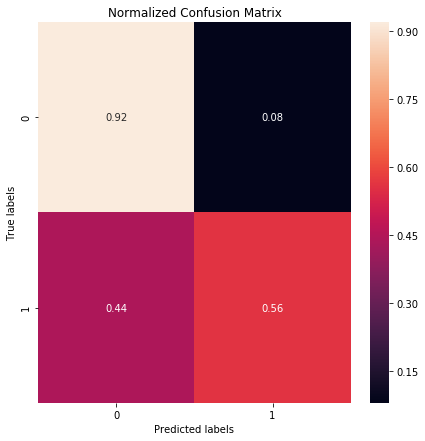



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     51007
           1       0.80      0.56      0.66     29851

    accuracy                           0.79     80858
   macro avg       0.79      0.74      0.75     80858
weighted avg       0.79      0.79      0.78     80858



In [0]:
predict_labels = []
for p in pred:
  if p > 0.6:
    predict_labels.append(1)
  else:
    predict_labels.append(0)


plt.figure(figsize=(7, 7))
ax= plt.subplot()
conf_mat = confusion_matrix(test['is_duplicate'].values, predict_labels)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Normalized Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
plt.show()

print('\n')
print('Classification Report:')
print(classification_report(test['is_duplicate'].values, predict_labels))

Analyse the output from neural net by visualising the loss and accuracy.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'

with open(path + 'trainHistoryDict', 'rb') as fp:
  model_history = pickle.load(fp)

epochs = len(model_history['acc'])

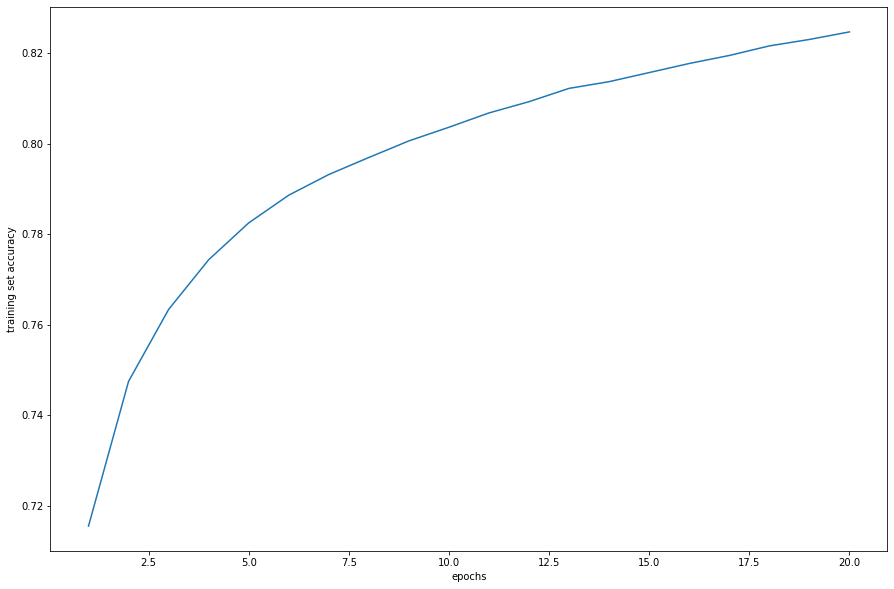

In [0]:
plt.figure(figsize = (15, 10))
plt.plot(np.linspace(1, epochs, epochs), malstm_history['acc'])
plt.xlabel('epochs')
plt.ylabel('training set accuracy')
plt.show()

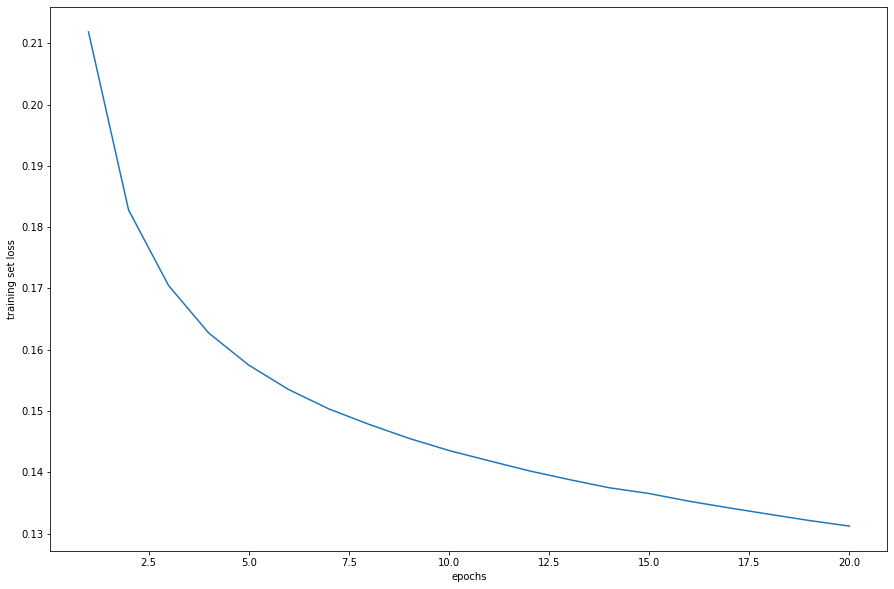

In [0]:
plt.figure(figsize = (15, 10))
plt.plot(np.linspace(1, epochs, epochs), malstm_history['loss'])
plt.xlabel('epochs')
plt.ylabel('training set loss')
plt.show()

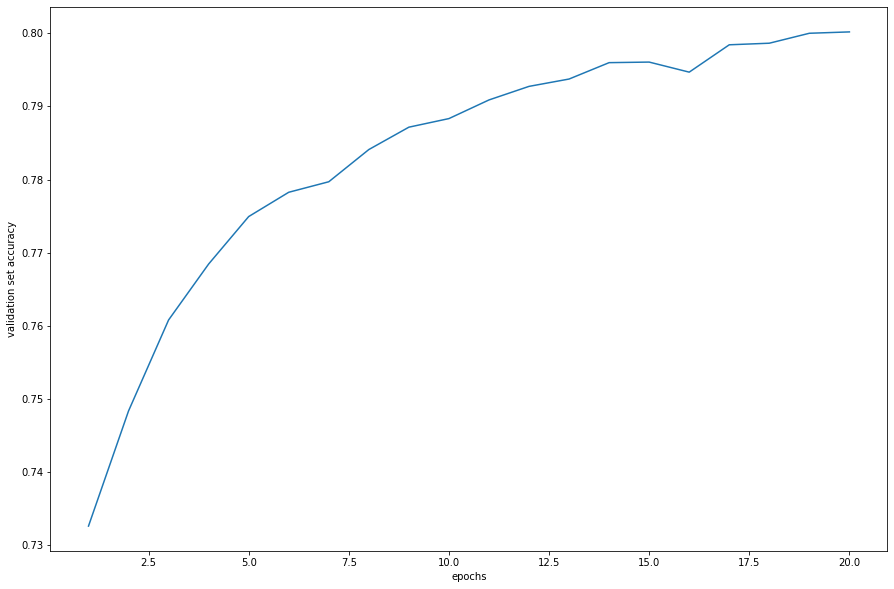

In [0]:
plt.figure(figsize = (15, 10))
plt.plot(np.linspace(1, epochs, epochs), malstm_history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('validation set accuracy')
plt.show()

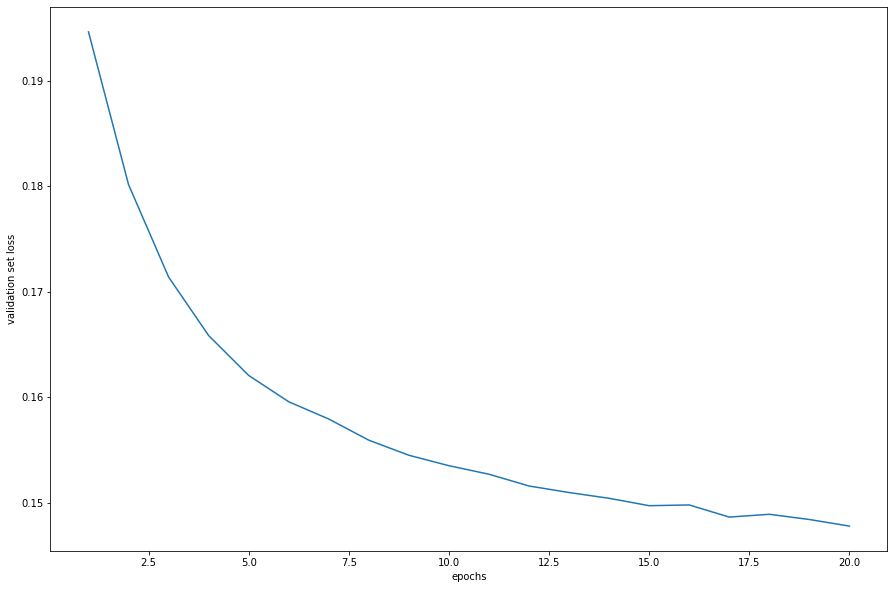

In [0]:
plt.figure(figsize = (15, 10))
plt.plot(np.linspace(1, epochs, epochs), malstm_history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation set loss')
plt.show()

In [0]:
model_stats = pd.DataFrame(malstm_history)
model_stats

,loss,acc,val_loss,val_acc
0,0.211848,0.715465,0.194609,0.732589
1,0.182813,0.747442,0.180153,0.748342
2,0.170476,0.763338,0.171404,0.760787
3,0.162746,0.774322,0.165863,0.768439
4,0.157510,0.782473,0.162086,0.774932
5,0.153512,0.788599,0.159594,0.778255
6,0.150365,0.793167,0.157959,0.779693
7,0.147849,0.796931,0.155954,0.784099
8,0.145563,0.800599,0.154530,0.787160
9,0.143574,0.803617,0.153541,0.788335


#Prepare the answer dataset.

Load the answer dataset obtained from http://www.msmarco.org/dataset.aspx.
The one being used for this project is dev set under Question Answering V2.1.

In [0]:
answer_data = pd.read_json('/content/drive/My Drive/Colab Notebooks/nlp-final-project/dev_v2.1.json')

Clean the dataset.

In [0]:
stop_words = nltk.corpus.stopwords.words("english")
porter_stemmer = nltk.stem.PorterStemmer()

def cleanAnswers(x):
    for answer in x:
        if answer == 'No Answer Present.':
            return np.nan
        else:
            return answer

answer_data['answers'] = answer_data['answers'].apply(lambda x: cleanAnswers(x))

answer_data = answer_data.dropna(subset=['answers'])
answer_data = answer_data.drop(['passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'], axis=1)
answer_data['answer_tokenized'] = answer_data['answers'].apply(nltk.word_tokenize)
answer_data['answer_tokenized'] = answer_data['answer_tokenized'].apply(lambda answer: [token.strip().lower() for token in answer])
answer_data['answer_tokenized'] = answer_data['answer_tokenized'].apply(lambda data: [word for word in data if word not in stop_words])
answer_data['answer_tokenized'] = answer_data['answer_tokenized'].apply(lambda data: [token for token in data if token not in punctuation])
answer_data['answer_tokenized'] = answer_data['answer_tokenized'].apply(lambda data: [porter_stemmer.stem(word) for word in data])


Save the cleaned data such that we do not need to perform cleaning again.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'
answer_data.to_csv(path + 'answers.csv')

Load the cleaned answers dataset.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'
answer_data = pd.read_csv(path + 'answers.csv')

answer_data = pd.drop(['Unnamed: 0'], axis=1)
answer_data['answer_tokenized'] = answer_data['answer_tokenized'].apply(literal_eval)

In [0]:
dictionary = Dictionary(list(answer_data['answer_tokenized']))
answer_data['doc2bow'] = answer_data['answer_tokenized'].apply(dictionary.doc2bow)
corpus = list(answer_data['doc2bow'])
tfidf = TfidfModel(corpus)
answer_data['tfidf'] = answer_data['doc2bow'].apply(lambda x: tfidf[x])

def getTopNKeyWords(x, n):
    keywords = sorted(x, key=lambda tup: tup[1], reverse=True)
    if len(keywords) > n:
        return keywords[0:n]
    else:
        return keywords
    
answer_data['top_n_keywords'] = answer_data['tfidf'].apply(lambda x: getTopNKeyWords(x, 5))

Save the modified dataset again for future reference. Also, save the dictionary.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'
answer_data.to_csv(path + 'answers_topn.csv')
dictionary.save(path + 'answers_dictionary.dict')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#Put everything into action. Find a similar question if found otherwise give answer recommendation.

Load all the necessary files.

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/nlp-final-project/'

# load the questions content
with open(path + 'vocabulary.p', 'rb') as fp:
  question_vocabulary = pickle.load(fp)

data_token = pd.read_csv(path + 'data_token.csv')
train = pd.read_csv(path + 'train_split.csv')
test = pd.read_csv(path + 'test_split.csv')
train = train.drop(['Unnamed: 0'], axis=1)
test = test.drop(['Unnamed: 0'], axis=1)
data_token = data_token.drop(['Unnamed: 0', 'q1_tokenized', 'q2_tokenized', 'is_duplicate'], axis=1)
train['q1_tokenized_embed'] = train['q1_tokenized_embed'].apply(literal_eval)
train['q2_tokenized_embed'] = train['q2_tokenized_embed'].apply(literal_eval)
test['q1_tokenized_embed'] = test['q1_tokenized_embed'].apply(literal_eval)
test['q2_tokenized_embed'] = test['q2_tokenized_embed'].apply(literal_eval)


# load the answers content
answer_dictionary = Dictionary.load(path + 'answers_dictionary.dict')
answers = pd.read_csv(path + 'answers_topn.csv')
answers['doc2bow'] = answers['doc2bow'].apply(literal_eval)
answers['top_n_keywords'] = answers['top_n_keywords'].apply(literal_eval)
answer_corpus = list(answers['doc2bow'])


# load the saved model
#This will be allow us to determine similarity between two questions.
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
    
model = load_model(path + 'model.h5')

###Get the user question input. Set user input here.

In [0]:
# input_question = 'What is the speed of light?'
input_question = 'How can I overcome tension?'

Clean the user's query question and embed it aswell.

In [0]:
input_question_tokenized = nltk.word_tokenize(input_question)
input_question_tokenized = [token.strip().lower() for token in input_question_tokenized]
input_question_tokenized = [token for token in input_question_tokenized if (token not in nltk.corpus.stopwords.words('english') and token not in punctuation)]
input_question_tokenized = [nltk.stem.PorterStemmer().stem(token) for token in input_question_tokenized]

input_question_embedded = []
for token in input_question_tokenized:
  input_question_embedded.append(question_vocabulary[token])

In [0]:
comb_data = pd.concat([train, test])
comb_data['input_embed'] = ''
comb_data['input_embed'] = comb_data['input_embed'].apply(lambda x: input_question_embedded)

Create the query input for neural net model and zero pad the query question.

In [0]:
max_seq_length = max(comb_data['q1_tokenized_embed'].map(lambda x: len(x)).max(), comb_data['q2_tokenized_embed'].map(lambda x: len(x)).max())

query = {'left': comb_data['q1_tokenized_embed'], 'right': comb_data['input_embed']}
# Zero padding
for dataset, side in itertools.product([query], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

Make prediction and see if a duplicate question exists. In order to make prediction faster, I am only comparing with the first 30 questions.

In [0]:
prediction = model.predict([query['left'][0:30], query['right'][0:30]])

Check if there is a question match.

In [0]:
possible_question_matches = []
for i in range(0, len(prediction)):
  if prediction[i] > 0.8:
    possible_question_matches.append(i)

Provide the user with the duplicate question or answer suggestion

In [0]:
# This funcion will get answer suggestions.
def get_answer_suggestion():
  answer_dictionary.add_documents([input_question_tokenized])
  input_question_doc2bow = answer_dictionary.doc2bow(input_question_tokenized)
  answer_corpus.append(input_question_doc2bow)
  updated_tfidf = TfidfModel(answer_corpus)
  input_question_tfidf = updated_tfidf[input_question_doc2bow]

  possible_answers = []
  #loop over all answers
  for i, answer in enumerate(answers['top_n_keywords']):
    count_match_tokens = 0
    match_tokens = []
    for q_token in input_question_tfidf:
      for a_token in answer:
        if q_token[0] == a_token[0]:
          match_tokens.append(a_token)
          count_match_tokens +=1
    if count_match_tokens > 0:
      possible_answers.append((match_tokens, count_match_tokens, i))
          
  possible_answers = sorted(possible_answers, key=lambda tup: (len(tup[0]), tup[1]), reverse=True)

  return possible_answers

Display either the duplicate question or suggested answers. In this case only show top 3 answers.

In [0]:
if len(possible_question_matches) > 0:
  #This means we found a match
  matching_questions = []
  for index in possible_question_matches:
    print('Duplicate question found:', data_token.loc[comb_data.iloc[index]['id']].question1)
else:
  #No question match found.
  #Go over answers and provide a suggestion
  possible_answers = get_answer_suggestion()

  counter = 1
  for p_ans in possible_answers[0:3]:
    print('Answer suggestion', counter, ':', answers.iloc[p_ans[2]]['answers'])
    counter+=1

Duplicate question found: How do I overcome overcome tension?
